In [1]:
#def get_obs_id_from_h5dl1_file(h5dl1InName):
#"/dl1/event/telescope/parameters/tel_001"
#col name is obs_id
#print(h5file)
#print(table)
#print(table[:]['energy'])
#print("for node in h5file")
#for node in h5file:
#print(node)
#h5file = open_file(h5dl1InName, "a")
#table = h5file.root.dl1.event.telescope.parameters.tel_001
#obs_id=int(np.mean(table[:]['obs_id']))
#obs_id_std=np.std(table[:]['obs_id'])
#print(obs_id)
#print(np.std(table[:]['obs_id']))
#h5file.close()
#if (obs_id_std == 0.0) :
#return obs_id
#return -999
#
import pandas as pd
import numpy as np
import glob
import gc
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.coordinates import SkyCoord, AltAz, angular_separation
import astropy.units as u
from scipy.stats import binned_statistic
from scipy.signal import lombscargle
import h5py
from astropy.io import fits
from astropy.table import Table
from tables import open_file

In [2]:
df_mu=Table.read("./run_000/muon_run000.fits", format='fits').to_pandas()

In [3]:
df_mu['ring_center_r']=np.sqrt(df_mu['ring_center_x']*df_mu['ring_center_x'] + df_mu['ring_center_y']*df_mu['ring_center_y'])

In [4]:
df_mu.keys()

Index(['event_id', 'event_time', 'mc_energy', 'ring_size', 'size_outside',
       'ring_center_x', 'ring_center_y', 'ring_radius', 'ring_width',
       'good_ring', 'muon_efficiency', 'ring_containment', 'ring_completeness',
       'impact_parameter', 'impact_x_array', 'impact_y_array', 'radial_stdev',
       'radial_skewness', 'radial_excess_kurtosis', 'num_pixels_in_ring',
       'mean_pixel_charge_around_ring', 'hg_peak_sample', 'lg_peak_sample',
       'ring_center_r'],
      dtype='object')

In [5]:
df_mu_good=df_mu[df_mu['good_ring']==True]

In [6]:
df_mu_good=df_mu_good[['event_id','mc_energy','impact_x_array','impact_y_array']]

In [7]:
df_mu_good['impact_r_array']=np.sqrt(df_mu_good['impact_x_array']*df_mu_good['impact_x_array']+df_mu_good['impact_y_array']*df_mu_good['impact_y_array'])

In [8]:
df_mu_good

,event_id,mc_energy,impact_x_array,impact_y_array,impact_r_array
14,1500,0.017107,-1.713059,-8.438454,8.610580
33,3400,0.021559,5.022887,2.794852,5.748095
41,4300,0.015795,-5.517302,4.010468,6.820885
64,6700,0.019599,-4.080979,8.687803,9.598558
113,11800,0.020526,7.516921,-4.619052,8.822683
...,...,...,...,...,...
9037,957700,0.031177,0.075868,7.986598,7.986958
9173,972100,0.019962,-5.493371,7.332854,9.162307
9207,975500,0.016474,-0.367567,-3.228024,3.248884
9387,994800,0.025321,6.259232,3.505849,7.174187


In [9]:
h5file = open_file("./run_000/dl1_muon_run000.h5", "a")

In [10]:
the_h5_table=h5file.root.dl1.event.telescope.parameters.LST_LSTCam

In [11]:
h5_event_id=the_h5_table[:]['event_id']
h5_mc_core_e=the_h5_table[:]['mc_energy']
h5_mc_core_x=the_h5_table[:]['mc_core_x']
h5_mc_core_y=the_h5_table[:]['mc_core_y']

In [12]:
df_h5 = pd.DataFrame(np.array([h5_event_id,h5_mc_core_e,h5_mc_core_x,h5_mc_core_y]).transpose(), columns=['h5_event_id', 'mc_energy','h5_mc_core_x', 'h5_mc_core_y'])

In [13]:
df_h5['impact_r_array'] = np.sqrt(df_h5['h5_mc_core_x']*df_h5['h5_mc_core_x']+df_h5['h5_mc_core_y']*df_h5['h5_mc_core_y'])

In [14]:
df_h5_filter=df_h5[df_h5['h5_event_id'].isin(df_mu_good['event_id'].values)]

In [15]:
df_h5_filter

,h5_event_id,mc_energy,h5_mc_core_x,h5_mc_core_y,impact_r_array
14,1500.0,0.017107,8.540619,-2.243623,8.830403
33,3400.0,0.021559,-3.928153,8.423265,9.294179
42,4300.0,0.015795,-5.776220,-7.130515,9.176544
66,6700.0,0.019599,-6.319252,-5.713272,8.519063
117,11800.0,0.020526,2.780109,-2.604249,3.809346
...,...,...,...,...,...
9560,957700.0,0.031177,-7.156468,0.472839,7.172071
9704,972100.0,0.019962,-4.720030,-5.122269,6.965366
9738,975500.0,0.016474,4.319536,1.756801,4.663126
9931,994800.0,0.025321,-1.570009,7.501085,7.663629


In [16]:
len(df_h5)/10000.0

0.9984

(array([ 4.,  2., 23., 25., 48., 36., 23., 10.,  7.,  1.]),
 array([-5.14334938, -4.05878804, -2.97422669, -1.88966535, -0.805104  ,
         0.27945734,  1.36401869,  2.44858004,  3.53314138,  4.61770273,
         5.70226407]),
 <BarContainer object of 10 artists>)

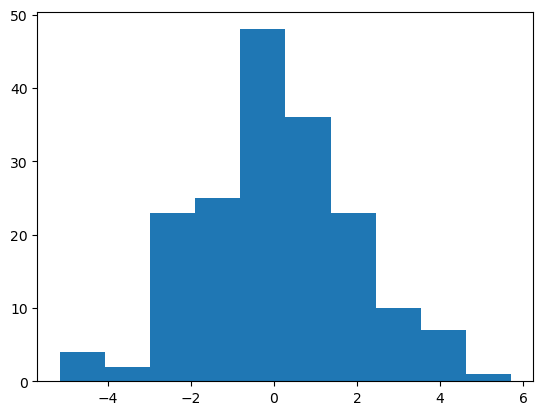

In [17]:
plt.hist(df_h5_filter['impact_r_array'].values-df_mu_good['impact_r_array'].values)

(array([ 4.,  2., 23., 25., 48., 36., 23., 10.,  7.,  1.]),
 array([-5.14334938, -4.05878804, -2.97422669, -1.88966535, -0.805104  ,
         0.27945734,  1.36401869,  2.44858004,  3.53314138,  4.61770273,
         5.70226407]),
 <BarContainer object of 10 artists>)

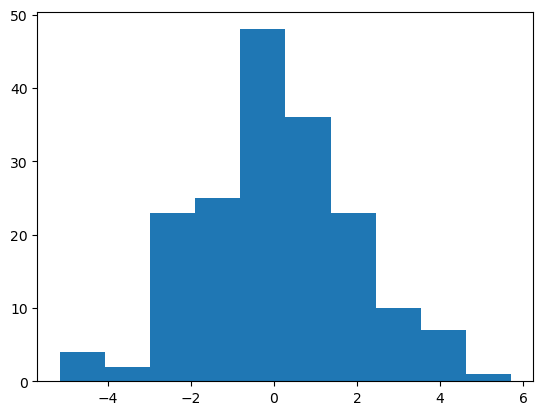

In [18]:
plt.hist(df_h5_filter['impact_r_array'].values-df_mu_good['impact_r_array'].values)

In [19]:
np.std(df_h5_filter['impact_r_array'].values-df_mu_good['impact_r_array'].values)

1.893459707838517

(array([ 9., 25., 26., 23., 20., 17., 20., 20., 11.,  8.]),
 array([-15.50514258, -12.69195193,  -9.87876128,  -7.06557064,
         -4.25237999,  -1.43918934,   1.3740013 ,   4.18719195,
          7.00038259,   9.81357324,  12.62676389]),
 <BarContainer object of 10 artists>)

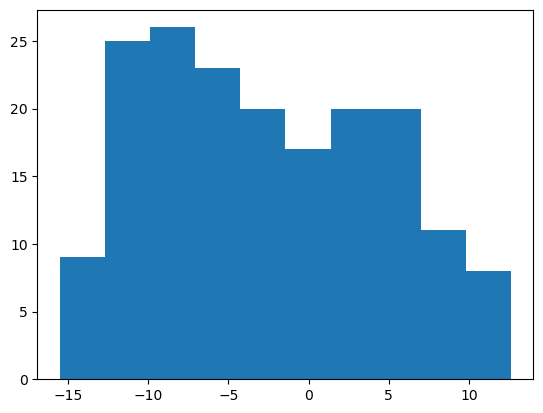

In [20]:
plt.hist(df_h5_filter['h5_mc_core_y'].values-df_mu_good['impact_y_array'].values)

In [21]:
df_mu_good_copy = df_mu_good.copy(deep=True)

In [22]:
std_y_list=[]
std_x_list=[]
i_list=[]
for i in np.arange(0,360, 1):
    df_mu_good_copy['impact_x_bar_array'] = df_mu_good_copy['impact_x_array']*np.cos(i/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.sin(i/180.0*np.pi)
    df_mu_good_copy['impact_y_bar_array'] = -df_mu_good_copy['impact_x_array']*np.sin(i/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.cos(i/180.0*np.pi)
    std_y=np.std(df_h5_filter['h5_mc_core_y'].values-df_mu_good_copy['impact_y_bar_array'].values)
    std_x=np.std(df_h5_filter['h5_mc_core_x'].values-df_mu_good_copy['impact_x_bar_array'].values)
    std_y_list.append(std_y)
    std_x_list.append(std_x)
    i_list.append(i)
    #print(i," ",std_y," ",std_x)

std_y_list=np.array(std_y_list)
std_x_list=np.array(std_x_list)
i_list=np.array(i_list)

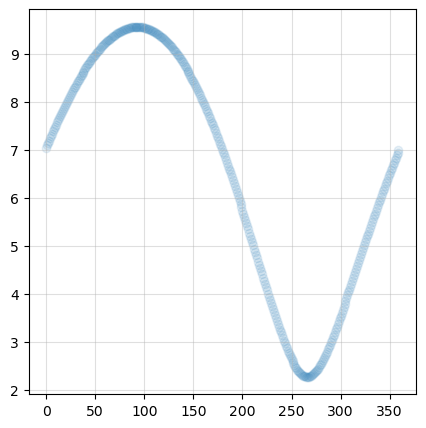

In [23]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(i_list,std_x_list,alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

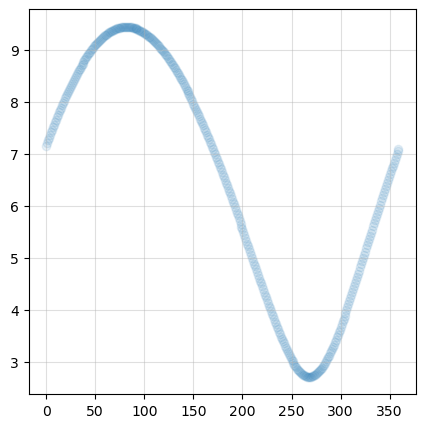

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(i_list,std_y_list,alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

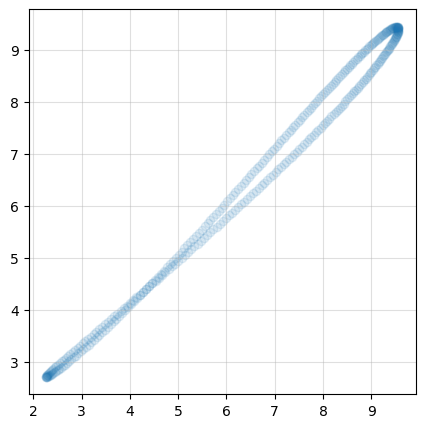

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(std_x_list,std_y_list,alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

In [26]:
print(np.argmin(std_y_list))
print(np.argmin(std_y_list))
print(360.0-i_list[268])

268
268
92.0


In [27]:
df_mu_good_copy['impact_x_bar_array'] = df_mu_good_copy['impact_x_array']*np.cos(268/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.sin(268/180.0*np.pi)
df_mu_good_copy['impact_y_bar_array'] = -df_mu_good_copy['impact_x_array']*np.sin(268/180.0*np.pi) + df_mu_good_copy['impact_y_array']*np.cos(268/180.0*np.pi)   

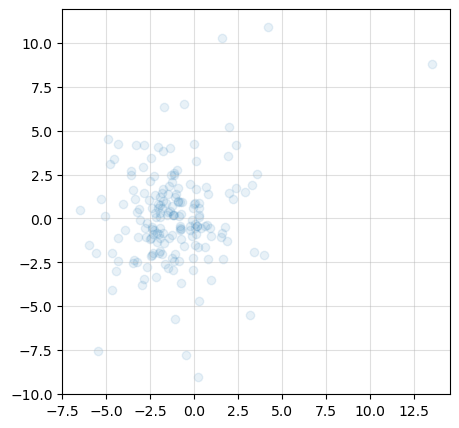

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter((df_mu_good_copy['impact_x_bar_array'].values-df_h5_filter['h5_mc_core_x'].values),(df_mu_good_copy['impact_y_bar_array'].values-df_h5_filter['h5_mc_core_y'].values),alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

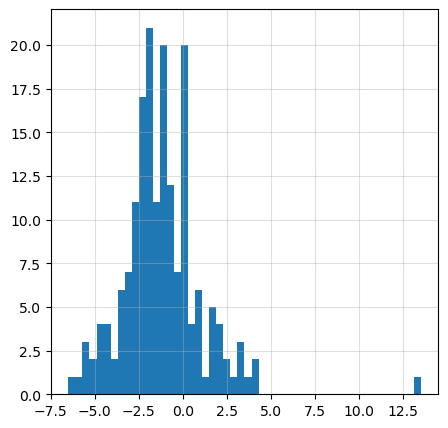

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist((df_mu_good_copy['impact_x_bar_array'].values-df_h5_filter['h5_mc_core_x'].values),bins=50,alpha=1)
ax.grid(True,alpha=0.4)
plt.show()

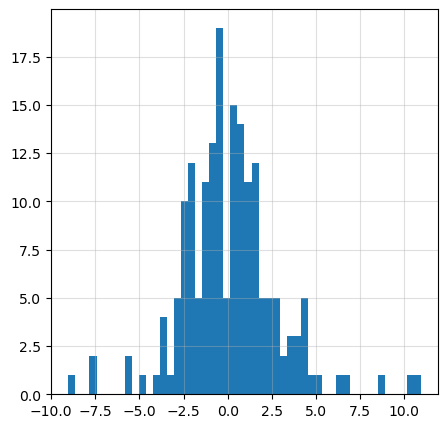

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist((df_mu_good_copy['impact_y_bar_array'].values-df_h5_filter['h5_mc_core_y'].values),bins=50,alpha=1)
ax.grid(True,alpha=0.4)
plt.show()

In [31]:
np.std(df_mu_good_copy['impact_y_bar_array'].values-df_h5_filter['h5_mc_core_y'].values)

2.7122776210255632

In [32]:
np.std(df_mu_good_copy['impact_x_bar_array'].values-df_h5_filter['h5_mc_core_x'].values)

2.273283121078508

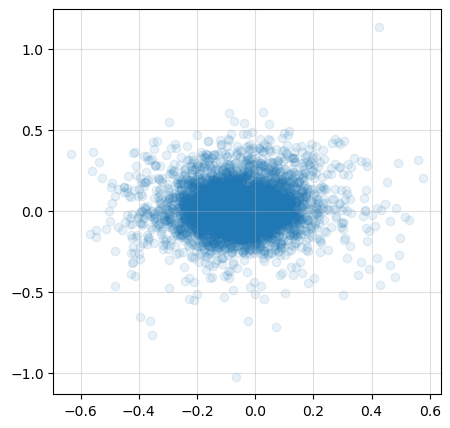

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu['ring_center_x'],df_mu['ring_center_y'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

#ax.legend()
    #ax.set_xlim(0,200)
#ax.set_yscale("log")
#a

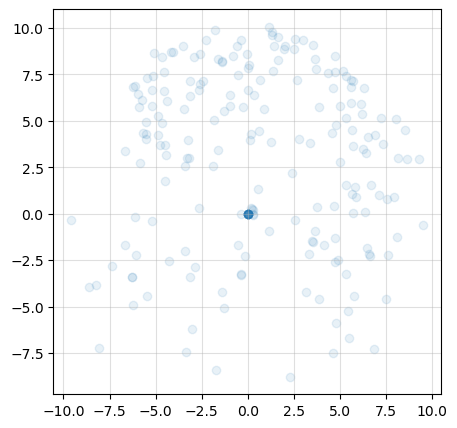

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu['impact_x_array'],df_mu['impact_y_array'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

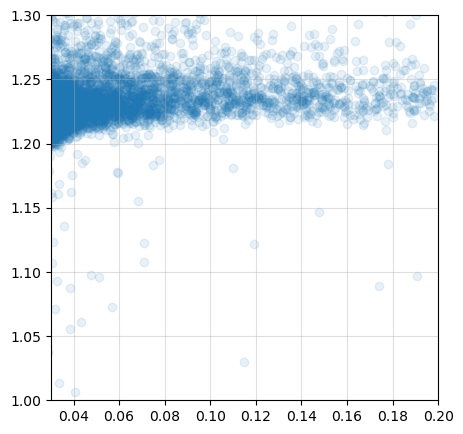

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu['mc_energy'],df_mu['ring_radius'],alpha=0.1)
ax.set_xlim(0.03,0.2)
ax.set_ylim(1.0,1.3)
ax.grid(True,alpha=0.4)
plt.show()

In [36]:
df_mu_all_good=df_mu[df_mu['good_ring']==True]

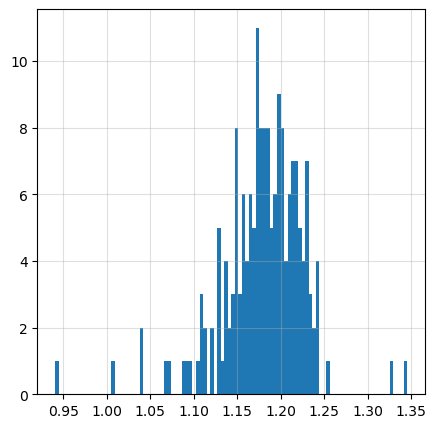

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(df_mu_all_good['ring_radius'].values,bins=100,alpha=1)
#ax.set_xlim(0.03,0.2)
#ax.set_ylim(1.0,1.3)
ax.grid(True,alpha=0.4)
plt.show()

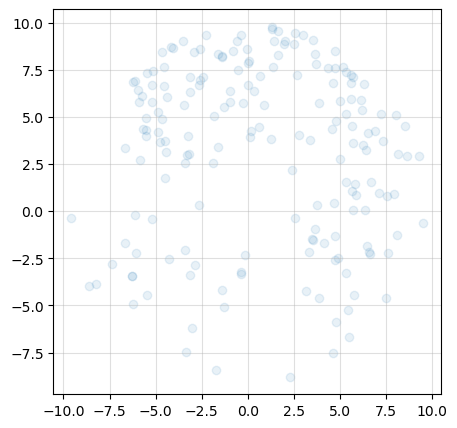

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_mu_all_good['impact_x_array'],df_mu_all_good['impact_y_array'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

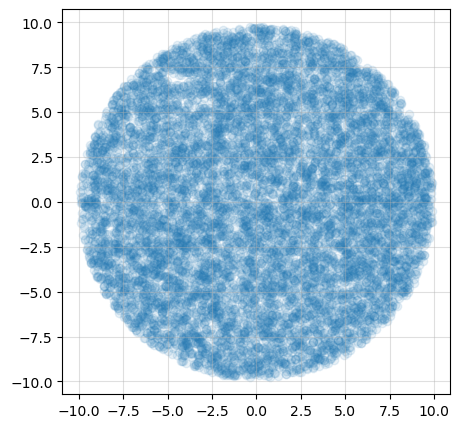

In [39]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(df_h5['h5_mc_core_x'],df_h5['h5_mc_core_y'],alpha=0.1)
ax.grid(True,alpha=0.4)
plt.show()

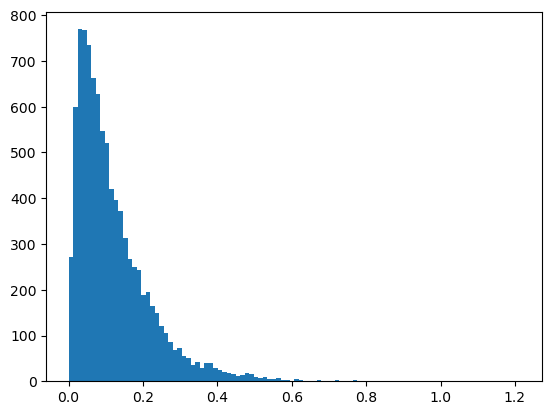

In [40]:
bins=plt.hist(df_mu['ring_center_r'].values, bins=100)

In [41]:
the_h5_table

/dl1/event/telescope/parameters/LST_LSTCam (Table(9984,)fletcher32, shuffle, blosc:zstd(1)) ''
  description := {
  "obs_id": Int32Col(shape=(), dflt=0, pos=0),
  "event_id": Int64Col(shape=(), dflt=0, pos=1),
  "intensity": Float64Col(shape=(), dflt=0.0, pos=2),
  "log_intensity": Float64Col(shape=(), dflt=0.0, pos=3),
  "x": Float64Col(shape=(), dflt=0.0, pos=4),
  "y": Float64Col(shape=(), dflt=0.0, pos=5),
  "r": Float64Col(shape=(), dflt=0.0, pos=6),
  "phi": Float64Col(shape=(), dflt=0.0, pos=7),
  "length": Float64Col(shape=(), dflt=0.0, pos=8),
  "length_uncertainty": Float64Col(shape=(), dflt=0.0, pos=9),
  "width": Float64Col(shape=(), dflt=0.0, pos=10),
  "width_uncertainty": Float64Col(shape=(), dflt=0.0, pos=11),
  "psi": Float64Col(shape=(), dflt=0.0, pos=12),
  "skewness": Float64Col(shape=(), dflt=0.0, pos=13),
  "kurtosis": Float64Col(shape=(), dflt=0.0, pos=14),
  "time_gradient": Float64Col(shape=(), dflt=0.0, pos=15),
  "intercept": Float64Col(shape=(), dflt=0.0, po

In [42]:
np.mean(df_mu['mc_energy'].values)

0.04073050329924444

<Axes: >

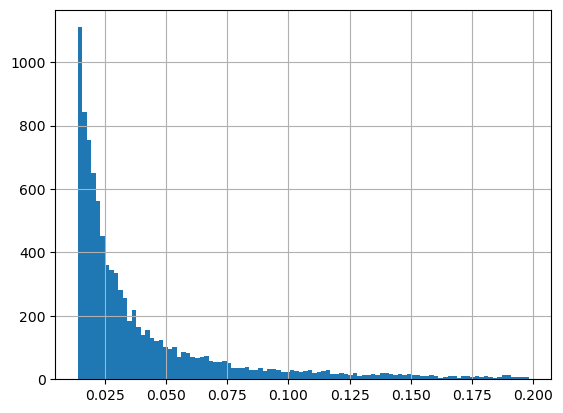

In [43]:
df_mu['mc_energy'].hist(bins=100)

In [44]:
np.mean(df_mu['ring_center_x'].values)

-0.042660467018568494

In [45]:
the_h5_table

/dl1/event/telescope/parameters/LST_LSTCam (Table(9984,)fletcher32, shuffle, blosc:zstd(1)) ''
  description := {
  "obs_id": Int32Col(shape=(), dflt=0, pos=0),
  "event_id": Int64Col(shape=(), dflt=0, pos=1),
  "intensity": Float64Col(shape=(), dflt=0.0, pos=2),
  "log_intensity": Float64Col(shape=(), dflt=0.0, pos=3),
  "x": Float64Col(shape=(), dflt=0.0, pos=4),
  "y": Float64Col(shape=(), dflt=0.0, pos=5),
  "r": Float64Col(shape=(), dflt=0.0, pos=6),
  "phi": Float64Col(shape=(), dflt=0.0, pos=7),
  "length": Float64Col(shape=(), dflt=0.0, pos=8),
  "length_uncertainty": Float64Col(shape=(), dflt=0.0, pos=9),
  "width": Float64Col(shape=(), dflt=0.0, pos=10),
  "width_uncertainty": Float64Col(shape=(), dflt=0.0, pos=11),
  "psi": Float64Col(shape=(), dflt=0.0, pos=12),
  "skewness": Float64Col(shape=(), dflt=0.0, pos=13),
  "kurtosis": Float64Col(shape=(), dflt=0.0, pos=14),
  "time_gradient": Float64Col(shape=(), dflt=0.0, pos=15),
  "intercept": Float64Col(shape=(), dflt=0.0, po

In [71]:
h5_out_obs_id=the_h5_table[:]['obs_id']
h5_out_event_id=the_h5_table[:]['event_id']
h5_out_mc_energy=the_h5_table[:]['mc_energy']
h5_out_mc_core_x=the_h5_table[:]['mc_core_x']
h5_out_mc_core_y=the_h5_table[:]['mc_core_y']
h5_out_mc_alt=the_h5_table[:]['mc_alt']
h5_out_mc_az=the_h5_table[:]['mc_az']

In [88]:
the_h5_table_image=h5file.root.dl1.event.telescope.image.LST_LSTCam

In [89]:
image_charge_arr=the_h5_table_image[:]['image']

In [90]:
image_time_arr=the_h5_table_image[:]['peak_time']

In [91]:
meta_data_arr=np.array([h5_out_obs_id,h5_out_event_id,h5_out_mc_energy,h5_out_mc_core_x,h5_out_mc_core_y,h5_out_mc_alt,h5_out_mc_az]).transpose()
meta_data_arr_columns=['obs_id','event_id','mc_energy','mc_core_x','mc_core_y','mc_alt','mc_az']

In [92]:
[meta_data_arr_columns.append(str('ch'+str(i))) for i in np.arange(len(the_h5_table_image[0]['image']))];

In [93]:
[meta_data_arr_columns.append(str('cht'+str(i))) for i in np.arange(len(the_h5_table_image[0]['image']))];

In [94]:
#for i in np.arange(len(the_h5_table_image[0]['image'])):
#    col_name=str('ch'+str(i))
#    meta_data_arr_columns.append(col_name)

In [95]:
df_h5_out = pd.DataFrame(np.column_stack((meta_data_arr,image_charge_arr,image_time_arr)), columns=meta_data_arr_columns)

In [96]:
print(the_h5_table_image[:]['image'].shape)
print(meta_data_arr.shape)

(9984, 1855)
(9984, 7)


In [97]:
df_h5_out

,obs_id,event_id,mc_energy,mc_core_x,mc_core_y,mc_alt,mc_az,ch0,ch1,ch2,...,cht1845,cht1846,cht1847,cht1848,cht1849,cht1850,cht1851,cht1852,cht1853,cht1854
0,100.0,100.0,0.043764,5.265851,5.839925,1.396200,3.141083,1.728506,1.019590,1.884974,...,2.146833,5.259359,37.783646,37.652397,22.278975,1.979133,14.767467,8.926561,33.673206,34.548149
1,100.0,200.0,0.188201,5.852325,-5.821779,1.396314,3.141849,0.259989,0.282336,0.172243,...,34.270992,8.168234,21.660305,30.292444,34.355412,3.210904,4.177964,20.423679,23.200659,22.422804
2,100.0,300.0,0.023677,0.021167,5.211458,1.396264,3.141077,3.476025,1.667865,4.878283,...,21.142687,20.338453,37.641083,0.952235,14.313764,11.755533,21.721718,2.259111,17.578840,6.881151
3,100.0,400.0,0.017206,-7.965814,-5.719480,1.396132,3.141508,2.822277,0.473005,2.874394,...,32.002617,26.773031,13.797265,35.095100,24.856512,1.782466,37.636299,0.211813,35.305862,35.104240
4,100.0,500.0,0.020826,-0.077619,6.992402,1.396145,3.141931,1.803939,1.667865,2.147985,...,16.471476,3.049575,0.975088,21.662106,35.527870,0.621106,18.096462,36.923321,35.375759,22.141132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,100.0,999600.0,0.019139,-3.306893,-3.857464,1.396325,3.141129,3.186867,-0.099003,0.770312,...,20.057285,19.632822,19.588673,21.701300,7.190060,6.698928,5.905467,10.169498,6.622454,36.019844
9980,100.0,999700.0,0.022005,-6.014100,2.147953,1.396332,3.142337,1.175335,1.744133,2.761676,...,22.782633,0.281772,13.642262,2.777678,17.051987,13.460336,30.080507,9.437328,3.767727,0.042009
9981,100.0,999800.0,0.031409,-2.607592,-4.764127,1.396196,3.140775,3.451685,2.519521,0.106524,...,20.985319,10.735547,0.510835,11.824518,9.033742,16.826445,36.716774,25.371824,36.267891,8.846031
9982,100.0,999900.0,0.042862,0.117316,2.983726,1.396186,3.141992,1.389060,1.971928,2.749926,...,12.222626,19.856188,3.195211,12.235274,5.031684,34.040573,26.985405,21.517710,15.217849,10.533301


In [98]:
df_h5_out.to_csv('test.csv',sep=" ")

In [ ]:
np.shape(the_h5_table_image[:]['image'])

In [ ]:
plt.hist(the_h5_table_image[0]['image'],bins=100)

In [ ]:
the_h5_table_image[0]['image']

In [ ]:
df_h5_out.shape